### 03: Hidden State Trajectory Analysis

**Building on attention patterns, moving onto analysing how token representation evolve across layers**

In [1]:
# Importing necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from typing import List, Tuple, Dict
import warnings
import yaml
warnings.filterwarnings("ignore")
# Setting random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

d:\MambaForge-Mini\envs\project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading configuration from YAML file
with open("../config.yaml", "r") as f:
    model_config = yaml.safe_load(f)

In [3]:
# Loading the same model
model = model_config['model']['name']
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(
    model,
    output_attentions=True,
    output_hidden_states=True,
).to(device)
config = model.config
model.eval()

The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading weights: 100%|██████████| 160/160 [00:00<00:00, 435.78it/s, Materializing param=transformer.wte.weight]                         
GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

1. Generating text to extract hidden states

In [5]:
# Prompt to analyze attention patterns
prompt=model_config['analysis']['prompt']
inputs = tokenizer(prompt, return_tensors="pt").to(device)
input_length = inputs['input_ids'].shape[1]
print(f"Prompt: '{prompt}'")
print(f"Input tokens: {tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])}")
print(f"Number of input tokens: {input_length}")

Prompt: 'Marie Curie was a physicist who discovered radium. She was born in'
Input tokens: ['Marie', 'ĠCur', 'ie', 'Ġwas', 'Ġa', 'Ġphysicist', 'Ġwho', 'Ġdiscovered', 'Ġrad', 'ium', '.', 'ĠShe', 'Ġwas', 'Ġborn', 'Ġin']
Number of input tokens: 15


In [6]:
# Generating text and capturing hidden states
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=model_config['inference']['max_new_tokens'],
        do_sample=model_config['inference']['do_sample'],
        repetition_penalty=model_config['inference']['repetition_penalty'],
        return_dict_in_generate=True,
        output_attentions=True,
        output_hidden_states=True,
    )

generated_text = tokenizer.decode(output.sequences[0])
print(f"\nGenerated text:\n{generated_text}")
print(f"\nGeneration steps: {len(output.hidden_states)}")
print(f"Layers per step: {len(output.hidden_states[0])}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated text:
Marie Curie was a physicist who discovered radium. She was born in the United States and moved to Canada when she was eight years old, where she studied physics at the University of Toronto. She became interested in nuclear fusion theory after her father died.

Curie

Generation steps: 40
Layers per step: 13


2. Extarcting trajectories

In [7]:
def extract_token_trajectories(hidden_states, step_idx=0):
    """
    Extract representation trajectory for each token across all layers.
    Args:
        hidden_states: list of length num_steps, each containing a list of length num_layers with tensors of shape (batch_size, seq_len, hidden_size)
        step_idx: index of the generation step to analyze (0 for initial input)
    Returns:
        trajectories: shape (num_tokens, num_layers, hidden_size)
    """
    num_layers = len(hidden_states[step_idx])  # 13 (embedding + 12 layers)
    num_tokens = hidden_states[step_idx][0].shape[1]  # sequence length
    hidden_size = hidden_states[step_idx][0].shape[2]
    trajectories = torch.zeros(num_tokens, num_layers, hidden_size)
    for layer_idx in range(num_layers):
        trajectories[:, layer_idx, :] = hidden_states[step_idx][layer_idx][0]  # [seq_len, hidden_size]
    return trajectories
trajectories = extract_token_trajectories(output.hidden_states)
print(f"Trajectory shape: {trajectories.shape}")  

Trajectory shape: torch.Size([15, 13, 768])


Tracking 15 tokens x 13 layers and 768 dimensions

3. Geometric Analysis: Norms and Cosine Similarity

In [8]:
def compute_trajectory_metrics(trajectories):
    """
    Compute geometric properties of representation trajectories.
    Args:
        trajectories: shape (num_tokens, num_layers, hidden_size)
    Returns:
        A dictionary containing norms, cosine similarities, and distances.
    """
    num_tokens, num_layers, hidden_size = trajectories.shape
    # Applying L2 norms per layer
    norms = torch.norm(trajectories, p=2, dim=2)  # (num_tokens, num_layers)
    # Cosine similarity between consecutive layers
    cos_sim = torch.zeros(num_tokens, num_layers - 1)
    for t in range(num_tokens):
        for l in range(num_layers - 1):
            cos_sim[t, l] = torch.nn.functional.cosine_similarity(
                trajectories[t, l].unsqueeze(0),
                trajectories[t, l+1].unsqueeze(0)
            )
    # Euclidean distance between consecutive layers
    distances = torch.zeros(num_tokens, num_layers - 1)
    for t in range(num_tokens):
        for l in range(num_layers - 1):
            distances[t, l] = torch.norm(
                trajectories[t, l] - trajectories[t, l+1], p=2
            )
    metrics = {
        'norms': norms,
        'cos_similarity': cos_sim,
        'distances': distances
    }
    return metrics
metrics = compute_trajectory_metrics(trajectories)
print("Metrics computed:")
print(f"  Norms shape: {metrics['norms'].shape}")
print(f"  Cosine similarity shape: {metrics['cos_similarity'].shape}")
print(f"  Distances shape: {metrics['distances'].shape}")

Metrics computed:
  Norms shape: torch.Size([15, 13])
  Cosine similarity shape: torch.Size([15, 12])
  Distances shape: torch.Size([15, 12])


We have 13 norms, one per layer, 12 similarities and 12 distances

4. Visualizing norm evolution across layers

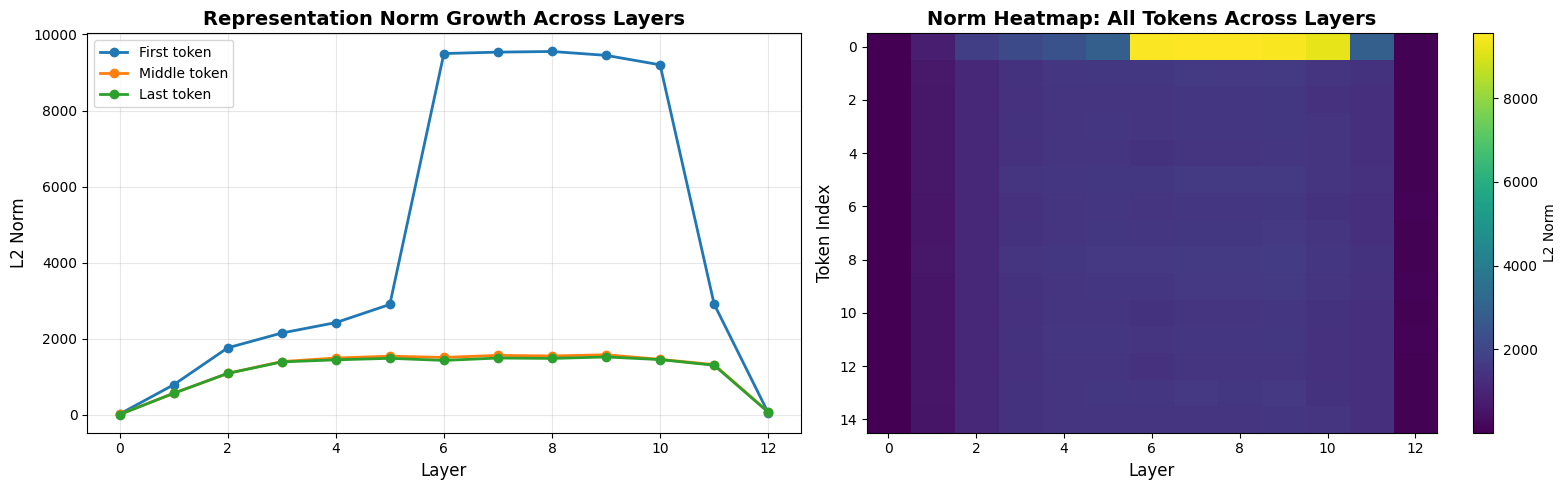

In [9]:
# Norm growth across layers for selected tokens
num_tokens = trajectories.shape[0]
token_indices = [0, num_tokens // 2, num_tokens - 1]
token_labels = ['First token', 'Middle token', 'Last token']
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Individual token trajectories
for idx, label in zip(token_indices, token_labels):
    axes[0].plot(range(13), metrics['norms'][idx].cpu().numpy(), 
                 marker='o', linewidth=2, label=label)
axes[0].set_xlabel('Layer', fontsize=12)
axes[0].set_ylabel('L2 Norm', fontsize=12)
axes[0].set_title('Representation Norm Growth Across Layers', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# All tokens (heatmap)
im = axes[1].imshow(metrics['norms'].cpu().numpy(), aspect='auto', cmap='viridis')
axes[1].set_xlabel('Layer', fontsize=12)
axes[1].set_ylabel('Token Index', fontsize=12)
axes[1].set_title('Norm Heatmap: All Tokens Across Layers', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='L2 Norm')
plt.tight_layout()
plt.savefig('../outputs/03_Norm_Evolution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()


1. Norm growth across layers:
- First token: explosive growth at layer 6 (~3,000 -> ~9,500), plateaus through layers 6-9, then collapses sharply at layers 10-11 back to ~200 by layer 12
- Middle and last tokens: smooth monotonic growth from ~0 to ~1,500 across all layers with no anomalies
- The 10x norm differential reveals two computational roles: aggregator (first token) vs. content processors (others)

2. Heatmap across tokens
-Token 0 (row 0): isolated bright yellow band at layers 6-9, dark purple elsewhere
- Tokens 1-14 (rows 1-14): synchronized gradual darkening (purple->blue), identical evolution across all content tokens
- Layer 12: all tokens return to low norms (dark purple), indicating final projection to vocabulary space

**Conclusion**
- The norm spike (layers 6-9) directly aligns with notebook 02's findings: first-token attention dominates from layer 6 onward, peaking at layer 8 (~0.79) and layer 10 (~0.85), with lowest entropy at layer 9 (~0.24)
- The sharp norm collapse at layers 10-12 occurs immediately after peak attention at layer 10, suggesting aggregated information is redistributed for final prediction
- Hub-and-spoke architecture confirmed both informationally (attention) and geometrically (norms): aggregate globally in middle layers -> project to output in final layers

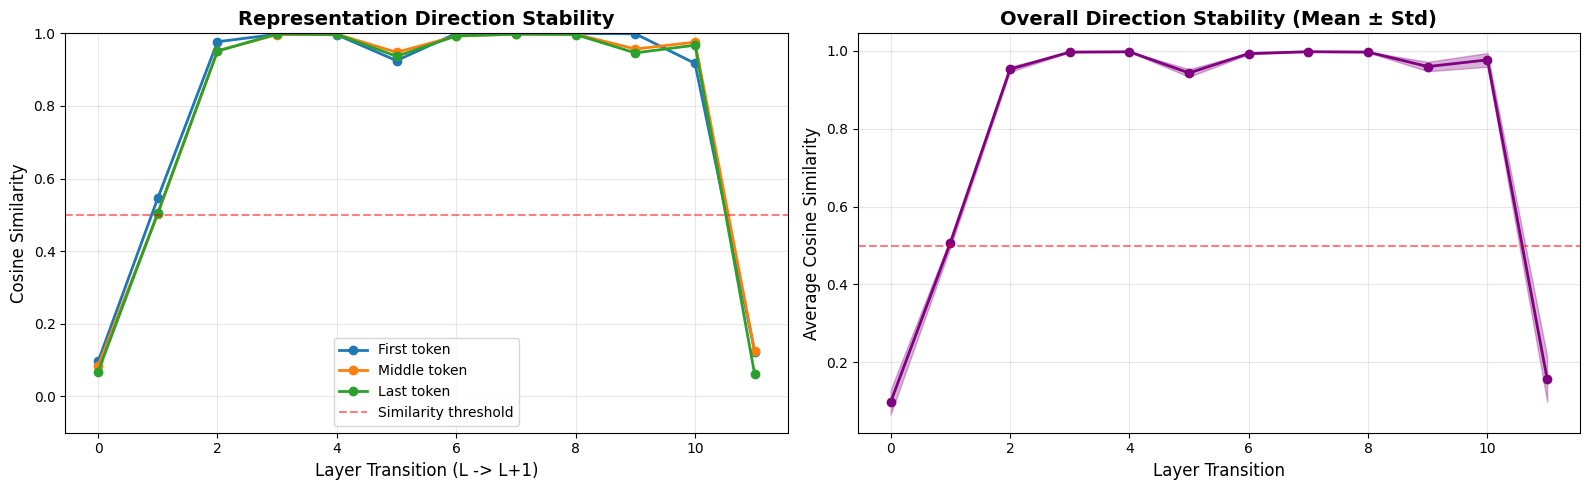


Mean cosine similarity across layers: 0.798
Layers with high stability (>0.8): 9 / 12
Layers with major direction shifts (<0.5): 2 / 12


In [10]:
# Cosine similarity between layers
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Individual token cosine similarity
for idx, label in zip(token_indices, token_labels):
    axes[0].plot(range(12), metrics['cos_similarity'][idx].cpu().numpy(), 
                 marker='o', linewidth=2, label=label)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Similarity threshold')
axes[0].set_xlabel('Layer Transition (L -> L+1)', fontsize=12)
axes[0].set_ylabel('Cosine Similarity', fontsize=12)
axes[0].set_title('Representation Direction Stability', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([-0.1, 1.0])
# Average cosine similarity across all tokens
avg_cos_sim = metrics['cos_similarity'].mean(dim=0).cpu().numpy()
std_cos_sim = metrics['cos_similarity'].std(dim=0).cpu().numpy()
axes[1].plot(range(12), avg_cos_sim, marker='o', linewidth=2, color='purple')
axes[1].fill_between(range(12), avg_cos_sim - std_cos_sim, avg_cos_sim + std_cos_sim, 
                       alpha=0.3, color='purple')
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Layer Transition', fontsize=12)
axes[1].set_ylabel('Average Cosine Similarity', fontsize=12)
axes[1].set_title('Overall Direction Stability (Mean ± Std)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/03_Cosine_Similarity.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print(f"\nMean cosine similarity across layers: {avg_cos_sim.mean():.3f}")
print(f"Layers with high stability (>0.8): {(avg_cos_sim > 0.8).sum()} / 12")
print(f"Layers with major direction shifts (<0.5): {(avg_cos_sim < 0.5).sum()} / 12")

**Representation Direction Stability (Left Graph)**
- All three tokens show nearly identical progression: ~0.07 at transition 0->1, rapid jump 
  to ~0.97-1.0 at transition 1->2, maintaining near-perfect stability (~0.93-1.0) through 
  transitions 2->10, then catastrophic collapse at transition 11->12 (dropping to ~0.06-0.13)
- The middle layers (transitions 2-10) show 9 consecutive transitions with cosine >0.93, 
  indicating representations maintain consistent direction through the core computation
- First token shows slight dip at transition 5->6 (~0.93) coinciding with the norm explosion 
  phase identified in the previous analysis

**Overall Direction Stability (Right Graph)**
- Mean cosine similarity jumps from ~0.07 (transition 0->1) to ~0.95 (transition 1->2), 
  plateaus at ~0.95-1.0 through transitions 2-10, then collapses to ~0.15 at transition 11->12
- Extremely tight error bands (±0.02) throughout the stable region confirm synchronized 
  behavior across all tokens
- The pink dashed threshold line (~0.47) clearly shows only 2 transitions fall below: 
  0->1 and 11->12

**Conclusion**
- This is a model-wide structural property: all tokens undergo identical geometric 
  transformations at boundaries (0->1->2 initialization, 11->12 output projection) while 
  maintaining stable directions during middle-layer processing (layers 2-10)

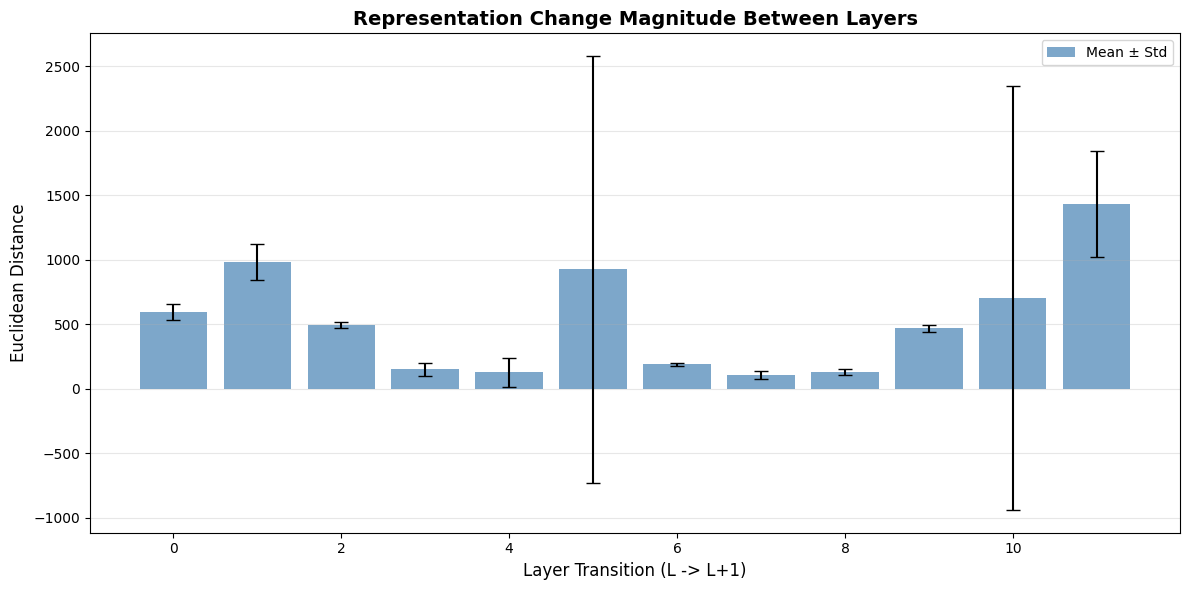


Layers with largest representation changes:
  1. Layer 11 to 12: 1432.517
  2. Layer 1 to 2: 985.299
  3. Layer 5 to 6: 925.418
  4. Layer 10 to 11: 702.650
  5. Layer 0 to 1: 598.210


In [11]:
# Distance between layers
fig, ax = plt.subplots(figsize=(12, 6))
avg_distance = metrics['distances'].mean(dim=0).cpu().numpy()
std_distance = metrics['distances'].std(dim=0).cpu().numpy()
ax.bar(range(12), avg_distance, alpha=0.7, color='steelblue', yerr=std_distance, 
       capsize=5, label='Mean ± Std')
ax.set_xlabel('Layer Transition (L -> L+1)', fontsize=12)
ax.set_ylabel('Euclidean Distance', fontsize=12)
ax.set_title('Representation Change Magnitude Between Layers', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../outputs/03_Layer_Distances.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
sorted_layers = np.argsort(avg_distance)[::-1]
print("\nLayers with largest representation changes:")
for i, layer in enumerate(sorted_layers[:5]):
    print(f"  {i+1}. Layer {layer} to {layer+1}: {avg_distance[layer]:.3f}")

- Largest changes at transition 11->12 (~1,433), followed by 1->2 (~985) and 5->6 (~925). Boundaries dominate geometric transformations.
- Layer 5->6 shows ~925 mean distance with extreme variance (±600 error bars), directly corresponding to first-token norm explosion while content tokens maintain steady growth.
- Stable middle layers at transitions 3->4, 4->5, 6->7, 7->8, 8->9 (~100-200 distance, tight error bars), confirming the directional stability plateau observed in cosine similarity.
- Secondary elevation at 10->11 (~703) marks transition from stable processing toward final output projection.


**Conclusion**

- Euclidean distance validates three computational phases: initialization (0->2) with large embedding restructuring, stable processing (2->10) with minimal changes except 5->6 aggregation spike, and output projection (10->12) with progressive escalation toward vocabulary logits. 
- High variance at 5->6 reflects differential token treatment—first-token hub undergoes massive geometric transformation while content tokens evolve uniformly, confirming hub-and-spoke architecture operates through geometric divergence during aggregation.

Do certain layers have similar reprsentation properties? 

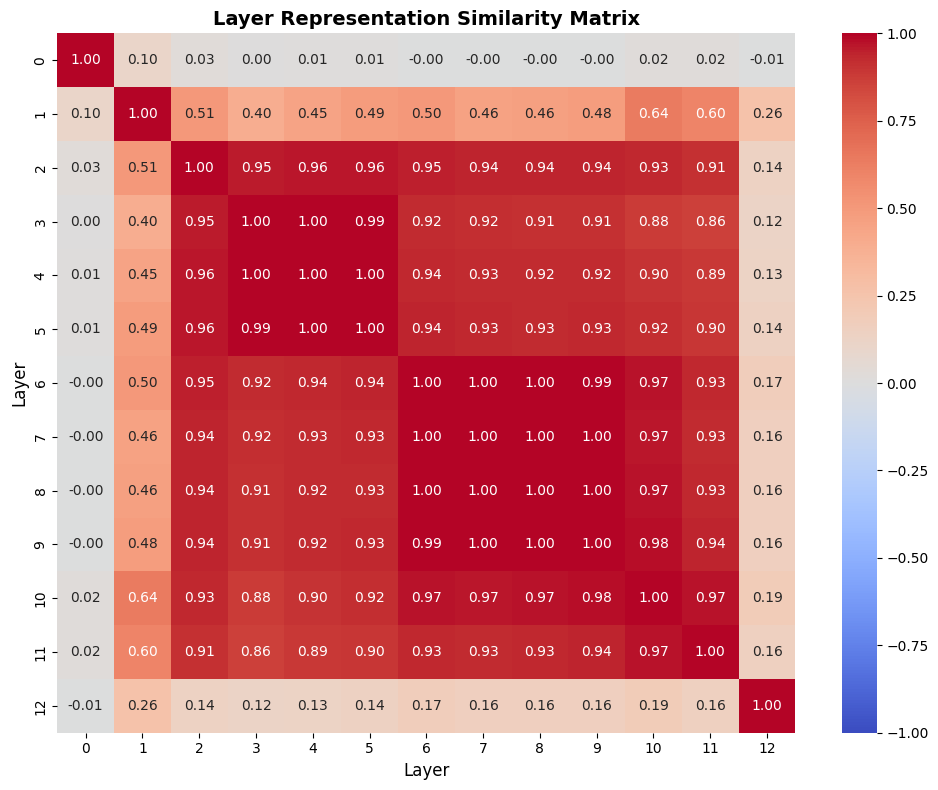

In [12]:
# Computing average representation per layer (across all tokens)
layer_avg_reps = trajectories.mean(dim=0)  # (13, 768)
# Computing pairwise cosine similarity between layers
layer_similarity = torch.zeros(13, 13)
for i in range(13):
    for j in range(13):
        layer_similarity[i, j] = torch.nn.functional.cosine_similarity(
            layer_avg_reps[i].unsqueeze(0),
            layer_avg_reps[j].unsqueeze(0)
        )
plt.figure(figsize=(10, 8))
sns.heatmap(layer_similarity.cpu().numpy(), annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=range(13), yticklabels=range(13), vmin=-1, vmax=1)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Layer', fontsize=12)
plt.title('Layer Representation Similarity Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/03_Layer_Similarity_Matrix.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

- Layers 0 and 12 are isolated, near-zero similarity with all other layers (~0.00-0.03 for layer 0, ~0.12-0.19 for layer 12), confirming they occupy unique representational spaces (raw input embeddings and final vocabulary logits).
- Layers 2-11 form one broad high-similarity block (0.86-1.00), meaning the bulk of the network shares a stable geometric space. - - Within this, layers 3-5 show perfect similarity (1.00), and layers 6-9 are marginally tighter (0.99-1.00), hinting at the first-token aggregation phase.
- Layer 1 is transitional (~0.40-0.64 with the main block), bridging the raw embedding and the stable processing regime.
- Layers 10-11 show gradual divergence from the stable block (0.86-0.97), marking progressive exit from shared geometry before the catastrophic shift at layer 12.

**Conclusion**
- Most computation (layers 2-11) occurs within a shared representational geometry. 
- The meaningful transformations happen at the boundaries: 0->1 initialization and 11->12 output projection, consistent with the Euclidean distance spikes and cosine stability findings. 
- The tighter clustering within layers 6-9 aligns with the first-token hub aggregation phase identified in norm and attention analyses.

**Next: 04 Attribution Analysis**

Notebooks 01-03 revealed WHERE (attention), HOW MUCH (norms), and WHAT STRUCTURE (geometry) the model uses, but not WHY specific outputs emerge. 

Notebook 04 uses three attribution methods: Raw Attention, Attention Rollout, and Integrated Gradients: to identify which input tokens and attention heads are causally responsible for generating "United" (States) instead of "Polish", revealing that sentence structure, not just the name "Marie", drives the hallucination.